In [1]:
# imports

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

###### Displaying the images used in this assignment.

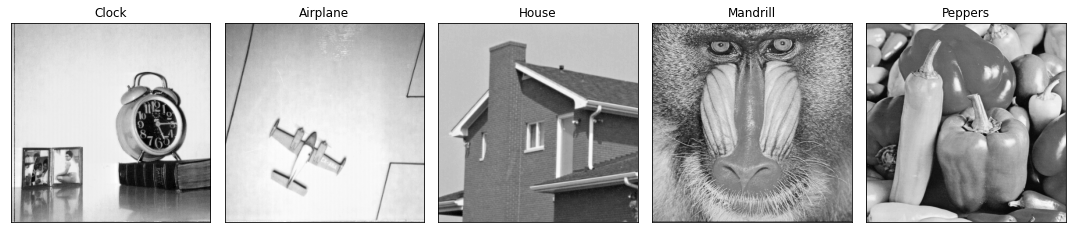

In [2]:
clock = plt.imread('5.1.12.tiff')
airplane = plt.imread('5.1.11.tiff')
houseimg = Image.open('4.1.05.tiff')
house = np.array(houseimg.convert('L'))
mandrillimg = Image.open('4.2.03.tiff')
mandrill = np.array(mandrillimg.convert('L'))
peppersimg = Image.open('4.2.07.tiff')
peppers = np.array(peppersimg.convert('L'))

images = [clock, airplane, house, mandrill, peppers]
names = ['Clock', 'Airplane', 'House', 'Mandrill', 'Peppers']

fig = plt.figure(figsize = (15,4))
rows = 1
cols = 5
for i in range(1,cols+1):
    fig.add_subplot(rows,cols,i)
    plt.imshow(images[i-1], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i-1])
    
plt.tight_layout()

## Q1 - Periodic Convolution

###### Write a program to do the following:

###### 1. Circularly convolve two images. Test your program by using an image and an averaging filter of size 5 × 5.

In [3]:
def circularly_convolve(image1, image2):
    
    N,M = image1.shape
    N1, M1 = image2.shape
    
    result = np.zeros((N,M))
    
    for i in range(N):
        for j in range(M):
            res = 0
            for n in range(N1):
                for m in range(M1):
                    res += image1[(i-n)%N][(j-m)%M] * image2[n][m]
            result[i][j] = res
    
    return result

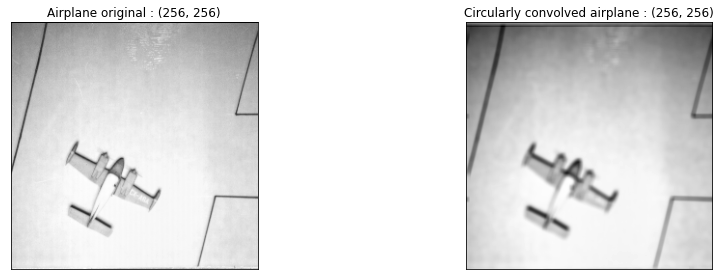

In [4]:
# testing on airplane image

average_filter = np.ones((5,5))/25
circular_conv_airplane = circularly_convolve(airplane, average_filter)

images = [airplane, circular_conv_airplane]
names = [f'Airplane original : {airplane.shape}', f'Circularly convolved airplane : {circular_conv_airplane.shape}']

fig = plt.figure(figsize = (15,4))
rows = 1
cols = 2
for i in range(1,cols+1):
    fig.add_subplot(rows,cols,i)
    plt.imshow(images[i-1], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i-1])
    
plt.tight_layout()

###### 2. Linearly convolve the same image and filter using the circular convolution function above after appropriate zero padding.

In [5]:
def pad_image(target_size, image):
    
    N,M = image.shape
    padded = np.zeros(target_size, dtype = complex)
    
    padded[:N, :M] = image
            
    return padded

def linearly_convolve(image1, image2):
    
    N,M = image1.shape
    N1, M1 = image2.shape
    padded_image = pad_image((N+N1-1, M+M1-1), image1)
    padded_filter = pad_image((N1+N1-1, M1+M1-1), image2)

    linear_conv = circularly_convolve(padded_image, padded_filter)
    return linear_conv

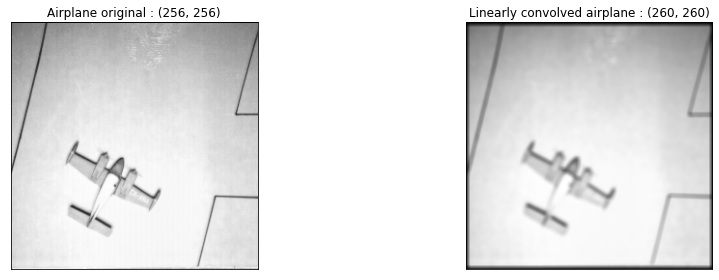

In [6]:
# testing on airplane image

linear_conv_airplane = linearly_convolve(airplane, average_filter)

images = [airplane, linear_conv_airplane]
names = [f'Airplane original : {airplane.shape}', f'Linearly convolved airplane : {linear_conv_airplane.shape}']

fig = plt.figure(figsize = (15,4))
rows = 1
cols = 2
for i in range(1,cols+1):
    fig.add_subplot(rows,cols,i)
    plt.imshow(images[i-1], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i-1])
    
plt.tight_layout()

###### 3. Now, verify that you can perform linear covolution using the DFT of zero padded images. 

In [7]:
def DFT2(img):
    
    # since M = N, both W_M and W_N matrices will be one and the same. Let it be W matrix.
    N = img.shape[1]
    
    def W_N_k_i(N,k,i):
        return np.exp(-2j * np.pi * k * i/ N)
    
    W = np.zeros((N, N), dtype = complex)
    
    for r in range(N):
        for c in range(N):
            W[r][c] = W_N_k_i(N, r, c)
            
    return np.matmul(W, np.matmul(img, W))  
    
    
def IDFT2(DFT):
    
    N = DFT.shape[1]
    
    def W_N_k_i(N,k,i):
        return np.exp(2j * np.pi * k * i/ N)
    
    W_inv = np.zeros((N, N), dtype = complex)
    
    for r in range(N):
        for c in range(N):
            W_inv[r][c] = W_N_k_i(N, r, c)
            
    return np.matmul(W_inv, np.matmul(DFT, W_inv)) / (N*N)  

In [8]:
def linearly_convolve_using_DFT(image1, image2):
    
    N,M = image1.shape
    N1, M1 = image2.shape
    
    padded_image1 = pad_image((N+N1-1, M+M1-1), image1)
    padded_image2 = pad_image((N+N1-1, M+M1-1), image2)
    
    image_DFT = DFT2(padded_image1)
    filter_DFT = DFT2(padded_image2)
    
    res = np.multiply(image_DFT, filter_DFT)
    res_IDFT = np.abs(IDFT2(res))
    
    return res_IDFT

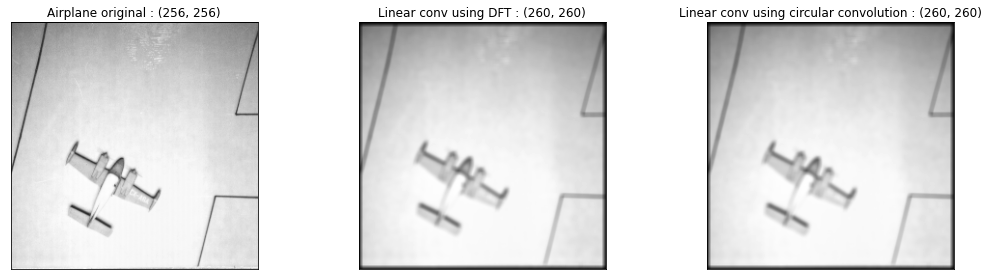

In [9]:
# testing on APC image

linear_conv_airplane2 = linearly_convolve_using_DFT(airplane, average_filter)

images = [airplane, linear_conv_airplane2, linear_conv_airplane]
names = [f'Airplane original : {airplane.shape}', f'Linear conv using DFT : {linear_conv_airplane2.shape}',
         f'Linear conv using circular convolution : {linear_conv_airplane.shape}']

fig = plt.figure(figsize = (15,4))
rows = 1
cols = 3
for i in range(1,cols+1):
    fig.add_subplot(rows,cols,i)
    plt.imshow(images[i-1], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i-1])
    
plt.tight_layout()

## Q2 - Image Denoising using linear filters

###### Use additive white Gaussian noise (AWGN) with zero mean and std $\sigma$ = 25. 

In [10]:
awgn = np.random.normal(loc = 0, scale = 25, size = clock.shape)
noisy_clock = clock + awgn

###### 1. Average filter of size M × M. Vary M from 3 to 15 in increments of 2 and observe the tradeoff between denoising and smoothing. 

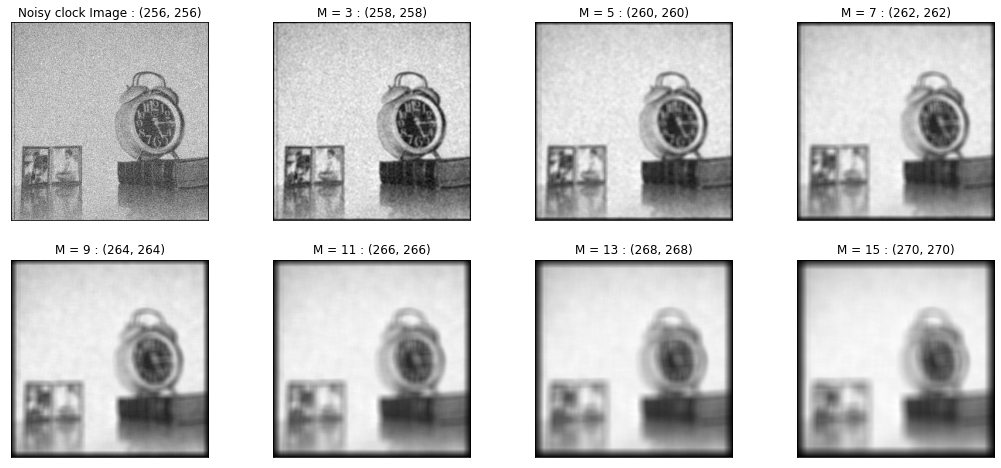

In [11]:
def denoise(M, noisy_image):
    
    averaging_filter = np.ones((M,M))/(M*M)
    denoised = linearly_convolve_using_DFT(noisy_image, averaging_filter)
    return denoised

M_list = [3,5,7,9,11,13,15]

names = ['Noisy clock Image', 'M = 3', 'M = 5', 'M = 7', 'M = 9', 'M = 11', 'M = 13', 'M = 15']
images = [noisy_clock]
for M in M_list:
    images.append(denoise(M,noisy_clock))
    
fig = plt.figure(figsize = (18,8))
rows = 2
cols = 4
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    plt.imshow(images[i-1], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i-1] + f' : {images[i-1].shape}')

###### What could be an appropriate window size for this noise level?

As we keep increasing the window size, we see that the image becomes more blurred. This means that image is getting more smoothened, in addition to getting denoised. An appropriate window size can be decided by looking at the tradeoff between denoising and smoothing. Observing above images, we find M = 5 is an appropriate sweetspot, as the image is not looking much grainy (i.e., noise is not apparent), and the blur is not much too.

###### 2. Gaussian filter of size 5 × 5. Experiment with the standard deviation $\sigma_h$ of the filter from 0.5 to 5 in steps of 0.5 and observe its effect.

In [12]:
def generate_gauss_kernel(sigma):
        """
        Generates nD gaussian mask
        """
        m,n = [(ss - 1.0)/2.0 for ss in (5,5)]
        y,x = np.ogrid[-m:m+1, -n:n+1]
        h = np.exp( -(x*x + y*y) / (2.0 * sigma * sigma) )

        sumh = h.sum()
        if sumh != 0:
            h = h / sumh
            
        return h

def denoise_using_gaussian(noisy_image, gaussian_filter):
    
    denoised = linearly_convolve_using_DFT(noisy_image, gaussian_filter)
    return denoised

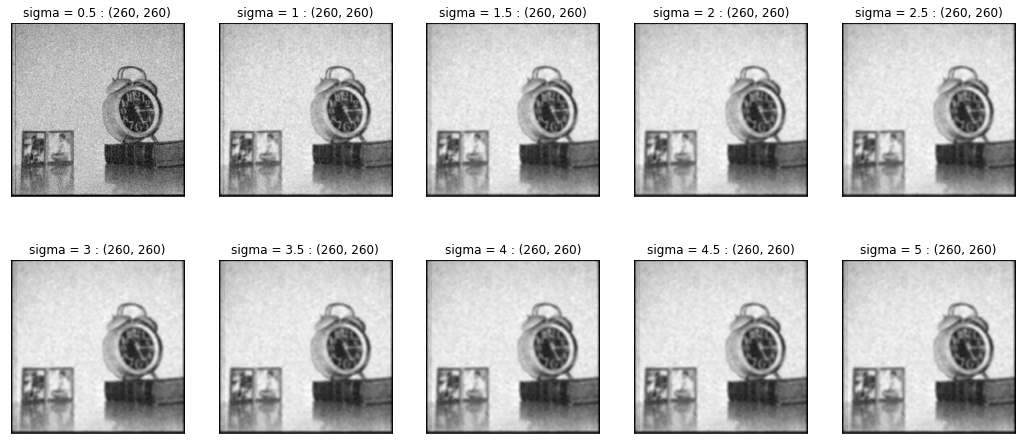

In [13]:
sigma_list = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

names = ['sigma = 0.5', 'sigma = 1', 'sigma = 1.5', 'sigma = 2', 'sigma = 2.5', 
         'sigma = 3', 'sigma = 3.5', 'sigma = 4', 'sigma = 4.5', 'sigma = 5']
images = []
for sigma in sigma_list:
    filter_ = generate_gauss_kernel(sigma)
    images.append(denoise_using_gaussian(noisy_clock, filter_))
    
fig = plt.figure(figsize = (18,8))
rows = 2
cols = 5
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    plt.imshow(images[i-1], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(names[i-1] + f' : {images[i-1].shape}')

As we increase $\sigma$, the pass band of the filter in frequency domain decreases. Which means, we are allowing less noise to pass through, as is apparent from the plain regions in images above. Therefore, the images with higher sigma have been denoised better. The change in shade of the image has to do with the properties of imshow function. One main advantage of gaussian filter over the low pass filter is that this does not blur the image too much.

## Question 3 - Image Quality Assessment

######  This problem is aimed at understanding the shortcomings of PSNR (MSE) in measuring image quality.

###### 1. Write a Python function that accepts a pair of images of identical dimensions and computes the MSE and PSNR between them.

In [14]:
def find_MSE_and_PSNR(image1, image2):
    
    image1 = image1.astype(np.float64)
    image2 = image2.astype(np.float64)

    MSE = np.zeros(image1.shape)
    N,M = image1.shape
    
    MSE = np.sum( (image1 - image2)**2 ) / (M*N)
    
    L = 255
    PSNR = 10 * np.log10(L**2 / MSE)
    
    return MSE, PSNR

###### 2. Write a Python function that accepts a pair of images of identical dimensions and computes the SSIM index between them.

In [15]:
def gaussian_filter(window_size, sigma):
    
    W = np.zeros((window_size, window_size))
    start = window_size//2
    stop = start+1
    for i in range(-start, stop):
        for j in range(-start, stop):
            W[i+start][j+start] = np.exp(-(i**2 + j**2) / (2 * sigma**2))
    W = W / np.sum(W)
    
    return W
    
def pad_for_SSIM(image):
    
    N,M = image.shape
    start = 5
    
    new_image = np.zeros((N+10, M+10))
    
    # central part
    new_image[start:N+start, start:M+start] = image
    
    # edges
    for i in range(5):
        new_image[i, start:M+start] = image[start-i-1, :]
        new_image[start:N+start, i] = image[:, start-i-1]
        new_image[N+start+i, start:M+start] = image[N-start+i, :]
        new_image[start:N+start, M+start+i] = image[:, M-start+i]
    
    # corners
    new_image[:start, :start] = image[0, 0]
    new_image[:start, M+start:] = image[0, M-1]
    new_image[N+start:, :start] = image[N-1, 0]
    new_image[N+start:, M+start:] = image[N-1, M-1]
    
    return new_image

In [16]:
def get_SSIM(image1, image2, window_size, sigma):

    N, M = image1.shape
    N1, M1 = window_size, window_size
    
    padded_image1 = pad_for_SSIM(image1)
    padded_image2 = pad_for_SSIM(image2)
    
    W = gaussian_filter(window_size, sigma)
    
    Mu1, Mu2 = np.zeros((N,M)), np.zeros((N,M))
    Sig1, Sig2 = np.zeros((N,M)), np.zeros((N,M))
    sigma12 = np.zeros((N,M))
    
    L, C, S, SSIM = np.zeros((N,M)), np.zeros((N,M)), np.zeros((N,M)), np.zeros((N,M))
    
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    C3 = C2/2
    
    for i in range(N):
        for j in range(M):
            
            Mu1[i][j] = np.sum(np.multiply(W, padded_image1[i : i+N1, j : j+M1]))
            Mu2[i][j] = np.sum(np.multiply(W, padded_image2[i : i+N1, j : j+M1])) 
            Sig1[i][j] = np.sqrt(np.sum(np.multiply(W, np.power(padded_image1[i : i+N1, j : j+M1] - Mu1[i][j], 2))))
            Sig2[i][j] = np.sqrt(np.sum(np.multiply(W, np.power(padded_image2[i : i+N1, j : j+M1] - Mu2[i][j], 2))))
            sigma12[i][j] = np.sum(W*(padded_image1[i: i+N1,j: j+M1] - Mu1[i][j])*(padded_image2[i: i+N1,j: j+M1] - Mu2[i][j]))
            
            L[i][j] = (2*Mu1[i][j]*Mu2[i][j] + C1)/(Mu1[i][j]**2 + Mu2[i][j]**2 + C1)
            C[i][j] = (2*Sig1[i][j]*Sig2[i][j] + C2)/(Sig1[i][j]**2 + Sig2[i][j]**2 + C2)
            S[i][j] = (sigma12[i][j] + C3)/(Sig1[i][j]*Sig2[i][j] + C3)
            
            SSIM[i][j] = L[i][j] * C[i][j] * S[i][j]
    
    return SSIM, np.average(SSIM)

###### Write a program to generate the following distortions.

In [17]:
def mean_shift(image):
    image = image + 16
    image[image>255] = 255
    return image

def awgn(image):
    noise = np.floor(np.random.normal(loc = 0, scale = 16, size = image.shape))
    image = image + noise
    image[image>255] = 255
    return image

def JPEG(image):
    image.save('Img.jpg', quality=10)
    img = Image.open('Img.jpg')
    return np.array(img.convert('L'))
    
def gaussian_blur(image):

    window = generate_gauss_kernel(2)
    return linearly_convolve_using_DFT(image, window)[2:-2, 2:-2]

###### Work with 3 images of your choice, and compute MSE, PSNR and SSIM index for each distortion.

In [18]:
# (a) Peppers

Peppers_original = peppers
Peppers_mean_shifted = mean_shift(peppers)
Peppers_with_awgn = awgn(peppers)
Peppers_jpeg = JPEG(peppersimg)
Peppers_gaussian_blur = gaussian_blur(peppers)

SSIM_mean_shifted, MSSIM_mean_shifted  = get_SSIM(Peppers_original, Peppers_mean_shifted, 11, 1)
SSIM_with_awgn, MSSIM_with_awgn = get_SSIM(Peppers_original, Peppers_with_awgn, 11, 1)
SSIM_jpeg, MSSIM_jpeg = get_SSIM(Peppers_original, Peppers_jpeg, 11, 1)
SSIM_gaussian_blur, MSSIM_gaussian_blur = get_SSIM(Peppers_original, Peppers_gaussian_blur, 11, 1)

MSE_mean_shifted, PSNR_mean_shifted = find_MSE_and_PSNR(Peppers_original, Peppers_mean_shifted)
MSE_with_awgn, PSNR_with_awgn= find_MSE_and_PSNR(Peppers_original, Peppers_with_awgn)
MSE_jpeg, PSNR_jpeg = find_MSE_and_PSNR(Peppers_original, Peppers_jpeg)
MSE_gaussian_blur, PSNR_gaussian_blur = find_MSE_and_PSNR(Peppers_original, Peppers_gaussian_blur)

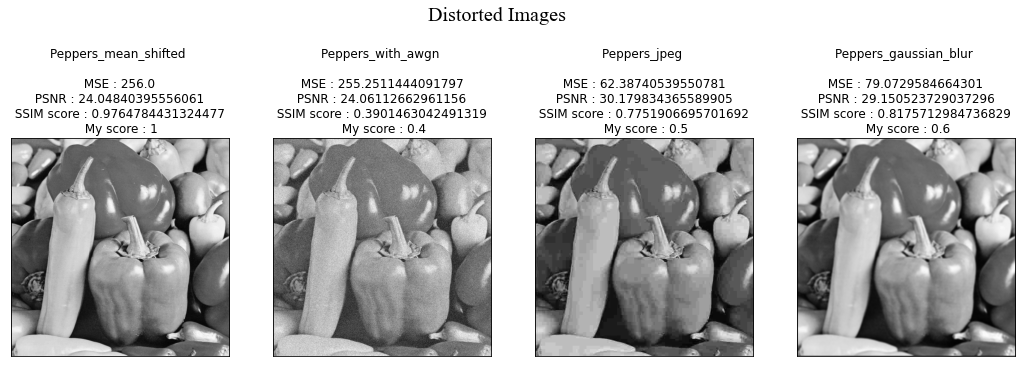

In [19]:
# Plotting original and distorted images

images = [Peppers_mean_shifted, Peppers_with_awgn, Peppers_jpeg, Peppers_gaussian_blur]
names = ['Peppers_mean_shifted', 'Peppers_with_awgn', 'Peppers_jpeg', 'Peppers_gaussian_blur']
MSEs = [MSE_mean_shifted, MSE_with_awgn, MSE_jpeg, MSE_gaussian_blur]
PSNRs_peppers = [PSNR_mean_shifted, PSNR_with_awgn, PSNR_jpeg, PSNR_gaussian_blur]
MSSIMs_peppers = [MSSIM_mean_shifted, MSSIM_with_awgn, MSSIM_jpeg, MSSIM_gaussian_blur]
My_scores_peppers = [1, 0.4, 0.5, 0.6]
    
fig = plt.figure(figsize = (18,7))
rows = 1
cols = 4
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{names[i]} \n\n MSE : {MSEs[i]} \n PSNR : {PSNRs_peppers[i]} \n SSIM score : {MSSIMs_peppers[i]} \n My score : {My_scores_peppers[i]}')
    
plt.suptitle('Distorted Images', font = 'Times New Roman', fontsize = 20)
plt.show()

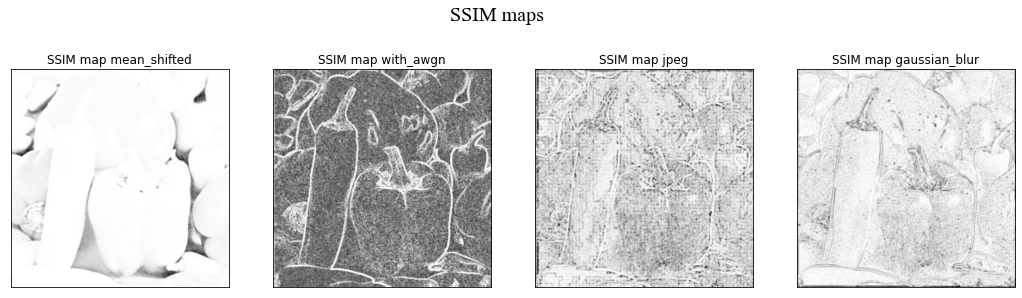

In [20]:
# Plotting SSIM maps

images = [SSIM_mean_shifted, SSIM_with_awgn, SSIM_jpeg, SSIM_gaussian_blur]
names = ['SSIM map mean_shifted', 'SSIM map with_awgn', 'SSIM map jpeg', 'SSIM map gaussian_blur']
    
fig = plt.figure(figsize = (18,5))
rows = 1
cols = 4
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{names[i]}')
    
plt.suptitle('SSIM maps', font = 'Times New Roman', fontsize = 20)
plt.show()

In [21]:
# (b) House

house_original = house
house_mean_shifted = mean_shift(house)
house_with_awgn = awgn(house)
house_jpeg = JPEG(houseimg)
house_gaussian_blur = gaussian_blur(house)

SSIM_mean_shifted, MSSIM_mean_shifted  = get_SSIM(house_original, house_mean_shifted, 11, 1)
SSIM_with_awgn, MSSIM_with_awgn = get_SSIM(house_original, house_with_awgn, 11, 1)
SSIM_jpeg, MSSIM_jpeg = get_SSIM(house_original, house_jpeg, 11, 1)
SSIM_gaussian_blur, MSSIM_gaussian_blur = get_SSIM(house_original, house_gaussian_blur, 11, 1)

MSE_mean_shifted, PSNR_mean_shifted = find_MSE_and_PSNR(house_original, house_mean_shifted)
MSE_with_awgn, PSNR_with_awgn= find_MSE_and_PSNR(house_original, house_with_awgn)
MSE_jpeg, PSNR_jpeg = find_MSE_and_PSNR(house_original, house_jpeg)
MSE_gaussian_blur, PSNR_gaussian_blur = find_MSE_and_PSNR(house_original, house_gaussian_blur)

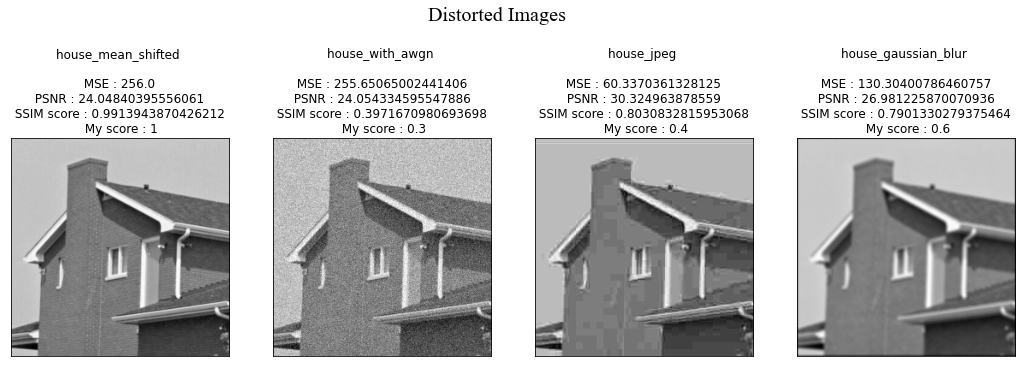

In [22]:
# Plotting original and distorted images

images = [house_mean_shifted, house_with_awgn, house_jpeg, house_gaussian_blur]
names = ['house_mean_shifted', 'house_with_awgn', 'house_jpeg', 'house_gaussian_blur']
MSEs = [MSE_mean_shifted, MSE_with_awgn, MSE_jpeg, MSE_gaussian_blur]
PSNRs_house = [PSNR_mean_shifted, PSNR_with_awgn, PSNR_jpeg, PSNR_gaussian_blur]
MSSIMs_house = [MSSIM_mean_shifted, MSSIM_with_awgn, MSSIM_jpeg, MSSIM_gaussian_blur]
My_scores_house = [1, 0.3, 0.4, 0.6]
    
fig = plt.figure(figsize = (18,7))
rows = 1
cols = 4
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{names[i]} \n\n MSE : {MSEs[i]} \n PSNR : {PSNRs_house[i]} \n SSIM score : {MSSIMs_house[i]} \n My score : {My_scores_house[i]}')
    
plt.suptitle('Distorted Images', font = 'Times New Roman', fontsize = 20)
plt.show()

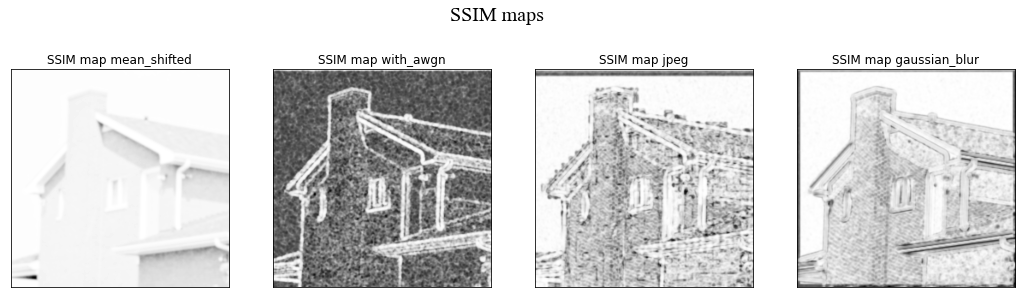

In [23]:
# Plotting SSIM maps

images = [SSIM_mean_shifted, SSIM_with_awgn, SSIM_jpeg, SSIM_gaussian_blur]
names = ['SSIM map mean_shifted', 'SSIM map with_awgn', 'SSIM map jpeg', 'SSIM map gaussian_blur']
    
fig = plt.figure(figsize = (18,5))
rows = 1
cols = 4
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{names[i]}')
    
plt.suptitle('SSIM maps', font = 'Times New Roman', fontsize = 20)
plt.show()

In [24]:
# (c) Mandrill

mandrill_original = mandrill
mandrill_mean_shifted = mean_shift(mandrill)
mandrill_with_awgn = awgn(mandrill)
mandrill_jpeg = JPEG(mandrillimg)
mandrill_gaussian_blur = gaussian_blur(mandrill)

SSIM_mean_shifted, MSSIM_mean_shifted  = get_SSIM(mandrill_original, mandrill_mean_shifted, 11, 1)
SSIM_with_awgn, MSSIM_with_awgn = get_SSIM(mandrill_original, mandrill_with_awgn, 11, 1)
SSIM_jpeg, MSSIM_jpeg = get_SSIM(mandrill_original, mandrill_jpeg, 11, 1)
SSIM_gaussian_blur, MSSIM_gaussian_blur = get_SSIM(mandrill_original, mandrill_gaussian_blur, 11, 1)

MSE_mean_shifted, PSNR_mean_shifted = find_MSE_and_PSNR(mandrill_original, mandrill_mean_shifted)
MSE_with_awgn, PSNR_with_awgn= find_MSE_and_PSNR(mandrill_original, mandrill_with_awgn)
MSE_jpeg, PSNR_jpeg = find_MSE_and_PSNR(mandrill_original, mandrill_jpeg)
MSE_gaussian_blur, PSNR_gaussian_blur = find_MSE_and_PSNR(mandrill_original, mandrill_gaussian_blur)

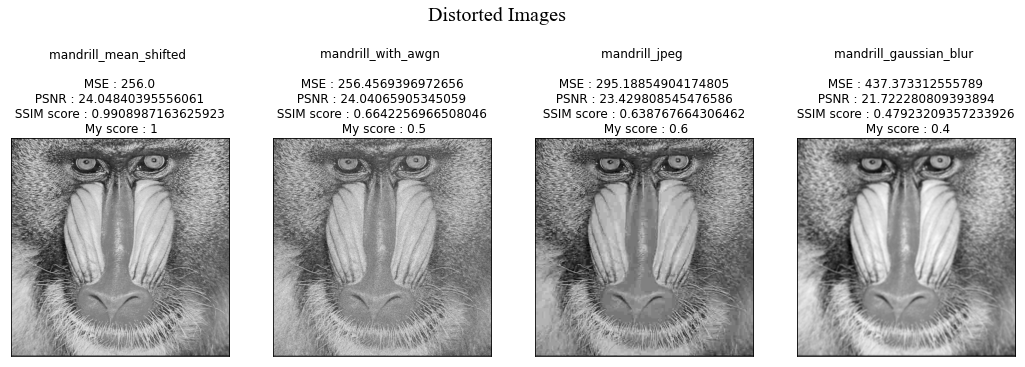

In [25]:
# Plotting original and distorted images

images = [mandrill_mean_shifted, mandrill_with_awgn, mandrill_jpeg, mandrill_gaussian_blur]
names = ['mandrill_mean_shifted', 'mandrill_with_awgn', 'mandrill_jpeg', 'mandrill_gaussian_blur']
MSEs = [MSE_mean_shifted, MSE_with_awgn, MSE_jpeg, MSE_gaussian_blur]
PSNRs_mandrill = [PSNR_mean_shifted, PSNR_with_awgn, PSNR_jpeg, PSNR_gaussian_blur]
MSSIMs_mandrill = [MSSIM_mean_shifted, MSSIM_with_awgn, MSSIM_jpeg, MSSIM_gaussian_blur]
My_scores_mandrill = [1, 0.5, 0.6, 0.4]
    
fig = plt.figure(figsize = (18,7))
rows = 1
cols = 4
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{names[i]} \n\n MSE : {MSEs[i]} \n PSNR : {PSNRs_mandrill[i]} \n SSIM score : {MSSIMs_mandrill[i]} \n My score : {My_scores_mandrill[i]}')
    
plt.suptitle('Distorted Images', font = 'Times New Roman', fontsize = 20)
plt.show()

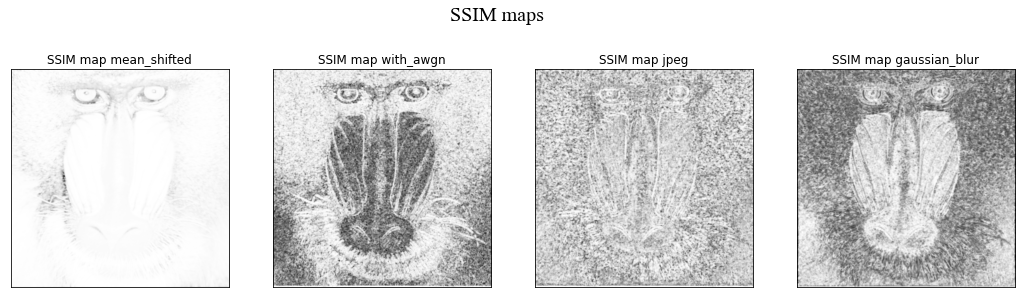

In [26]:
# Plotting SSIM maps

images = [SSIM_mean_shifted, SSIM_with_awgn, SSIM_jpeg, SSIM_gaussian_blur]
names = ['SSIM map mean_shifted', 'SSIM map with_awgn', 'SSIM map jpeg', 'SSIM map gaussian_blur']
    
fig = plt.figure(figsize = (18,5))
rows = 1
cols = 4
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{names[i]}')
    
plt.suptitle('SSIM maps', font = 'Times New Roman', fontsize = 20)
plt.show()

###### Compute the correlation between your scores and PSNR, your scores and SSIM.

In [27]:
# concatenating scores of all images

PSNRs = PSNRs_peppers + PSNRs_house + PSNRs_mandrill
MSSIMs = MSSIMs_peppers + MSSIMs_house + MSSIMs_mandrill

my_scores = My_scores_peppers + My_scores_house + My_scores_mandrill
len(MSSIMs)

12

In [28]:
Corr_PSNR_myscore = np.corrcoef(PSNRs, my_scores)[0][1]
Corr_SSIM_myscore = np.corrcoef(MSSIMs, my_scores)[0][1]

print(f'The correlation between PSNR and my scores is {Corr_PSNR_myscore}')
print(f'The correlation between SSIM score and my scores is {Corr_SSIM_myscore}')

The correlation between PSNR and my scores is -0.19236485896877453
The correlation between SSIM score and my scores is 0.8473565570540178


From the above two correlation coefficients, we can safely conclude that SSIM index is a better metric for comparison of images, atleast in perspective of HVS.